<a href="https://colab.research.google.com/github/dxbezerra/tvdi/blob/master/TVDI_projeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projeto TVDI**

Autores: Diego, Raíssa, Stella, Gustavo

Disciplina de Introdução à Programação (SER-307)

Instituto Nacional de Pesquisas Espaciais (INPE)


---

Temperature-Vegetation Dryness Index (TVDI) proposto por Sandholt et al. (2002).

SANDHOLT, I.; RASMUSSEN, K.; ANDERSEN, J. A simple interpretation of the surface temperature/vegetation index space for assessment of surface moisture status. **Remote Sensing of environment**, v. 79, n. 2-3, p. 213-224, 2002.

In [100]:
# Limpar dados e instalar módulos
!rm -rf sample_data
!rm -rf processed
!pip install pymodis
!git clone https://github.com/dxbezerra/tvdi.git

# Importar módulos
import gdal
from gdalconst import *
import numpy as np
from glob import glob
import scipy
from os import path as osp
import os, calendar, itertools, sys, subprocess
from pymodis import downmodis
from pymodis.convertmodis_gdal import convertModisGDAL
import matplotlib.pyplot as plt

fatal: destination path 'tvdi' already exists and is not an empty directory.


In [101]:
# Criar diretório dos dados
path = './raw_data'
if not osp.exists(path):
    os.mkdir(path)
print(os.listdir('./'))

['.config', 'tvdi', 'raw_data']


# **Download das imagens**
A partir da biblioteca pyModis realizamos o download das imagens de interesse. No caso, utilizamos o produto MOD13A2 que corresponde ao índices de vegetação NDVI e EVI composto de 16 dias e o produto MOD11A2 correspondente a Temperature Superficial do Solo (TSS) para de um intervalo de 8 dias.
O período analisado é referente ao dia juliano 257 (segunda quinzena de Setembro), que é o período mais seco no Estado do Ceará.

In [102]:
# Usuário e senha Earthdata
user     = 'grupo_tvdi'
password = 'Ninguempodesaber1'

# Cenas e produtos a serem baixados
tiles    = 'h14v09','h13v09'
products = ['MOD13A2.006', 'MOD11A2.006']

# Período selecionado
day     = '2018-09-14'
enddate = '2018-09-29'

# Download
print('Realizando download...')

for p in products:
  modisDown = downmodis.downModis(destinationFolder=path,
  password=password, user=user, tiles=tiles, product=p, today=day,
  enddate=enddate)

  modisDown.connect()
  modisDown.downloadsAllDay()

print('Download completo.')

# Checkar imagens baixadas e o seu tamanho em megabytes
fls = sorted(glob(path + '/*.hdf'))
for f in fls:
  print(osp.basename(f),'-', osp.getsize(f)/10e5, 'MB')

Realizando download...
Download completo.
MOD11A2.A2018257.h13v09.006.2018266035239.hdf - 6.701147 MB
MOD11A2.A2018257.h14v09.006.2018266035104.hdf - 3.322762 MB
MOD11A2.A2018265.h13v09.006.2018282164825.hdf - 6.699373 MB
MOD11A2.A2018265.h14v09.006.2018282165559.hdf - 3.339318 MB
MOD13A2.A2018257.h13v09.006.2018282125001.hdf - 19.171178 MB
MOD13A2.A2018257.h14v09.006.2018282125732.hdf - 7.887101 MB


# **Extrair bandas de interesse das imagens**
Tendo em vista que as imagens MODIS são contidas de diversas bandas (ex.: banda de qualidade do pixel, presença de nuvens, ângulo solar zenital, etc.), as bandas de interesse  são primeiramente extraídas com o módulo *convertModisGDAL*. Para o produto MOD13A2 utilizamos o NDVI e para o produto MOD11A2 a banda utilizada é a do TSS capturado durante o dia (*LST_Day_1km*), ambos sendo a primeira banda.

In [103]:
# Selecionar as datas julianas únicas das imagens baixadas (np.unique seleciona apenas valores que não se repetem)
juliandays = np.unique([osp.basename(f).split(".")[1][-3:] for f in fls]) # Retirar os dias julianos (MOD11A2.A2018(257).h13v09.006.2018266035239.hdf)

# Diretório de saída das bandas
path = './processed'
if not osp.exists(path):
  os.mkdir(path)

# Extrair bandas  
for f in fls:
  
  # Bandas selecionadas (Seleciona somente a primeira banda)
  subset = "1"
  
  # Extrair bandas com pymodis (obs: epsg é o código de reprojeção da imagem)
  fileout = osp.join(path, osp.basename(f)[:-4])
  extr = convertModisGDAL(f, fileout, subset, res=None, outformat='GTiff', epsg=4326)
  extr.run(quiet=True)
   
# Checkar bandas extraídas
fls = sorted(glob(path + '/*.tif'))
for f in fls:
  print(osp.basename(f))

MOD11A2.A2018257.h13v09.006.2018266035239_LST_Day_1km.tif
MOD11A2.A2018257.h14v09.006.2018266035104_LST_Day_1km.tif
MOD11A2.A2018265.h13v09.006.2018282164825_LST_Day_1km.tif
MOD11A2.A2018265.h14v09.006.2018282165559_LST_Day_1km.tif
MOD13A2.A2018257.h13v09.006.2018282125001_1 km 16 days NDVI.tif
MOD13A2.A2018257.h14v09.006.2018282125732_1 km 16 days NDVI.tif


#**Mosaicagem**
As imagens baixadas são correspondentes às cenas do MODIS (h14v09 e h13v09) e necessitam que sejam combinadas para o Estado do Ceará. Esse processo é realizado selecionando as imagens de mesmo produto e período, porém de cenas distintas. Mais adiante o GDAL é utilizado para criar o mosaico.

In [104]:
# Listas
products   = ['MOD13A2.006', 'MOD11A2.006']
juliandays = np.unique([osp.basename(f).split(".")[1][-3:] for f in fls])

# Selecionar imagens de mesmo produto e período, porém de cenas distintas
for p in products:
  p = p.split(".")[0]
  
  for jd in juliandays:

    # Selecionar todas as imagens criadas no passo anterior (bandas extraídas) para o mesmo produto
    glb = glob('./processed/{0}*.tif'.format(p))

    # Guardar imagens de cenas distintas de mesmo produto e de mesmo período em uma lista
    # pair = [im for im in glb if jd in im] # ver linhas abaixo
    
    pair = []
    for im in glb:
      if jd in im:
        pair.append(im)
    
    # Se a lista de imagens não for vazia, prosseguir.
    if not pair == []:
    
      # Remover espaços no nome do arquivo (pra não dar problema)
      rm_spaces = pair[0].replace(" ", "")
      
      # Criar um novo nome para arquivo de saída
      fname = rm_spaces[:-4] + ".MOSAIC.vrt"

      # Criar mosaico com o GDAL utilizando o shell
      gdal.BuildVRT(fname, pair)
      translateCmd = 'gdal_translate -of GTiff {0} {1}.tif'.format(fname, fname[:-4])
      subprocess.call(translateCmd, shell=True)

# Checkar mosaicos criados
fls = sorted(glob(path + '/*MOSAIC.tif'))
for f in fls:
  print(osp.basename(f))

MOD11A2.A2018257.h13v09.006.2018266035239_LST_Day_1km.MOSAIC.tif
MOD11A2.A2018265.h13v09.006.2018282164825_LST_Day_1km.MOSAIC.tif
MOD13A2.A2018257.h13v09.006.2018282125001_1km16daysNDVI.MOSAIC.tif


# **Recorte para área de interesse**
Para focarmos somente na área de nosso interesse, realizamos um recorte utilizando o arquivo *shapefile* dos limites estaduais do Ceará, evitando assim o processamento de dados irrelevantes posteriormente.

In [105]:
# Arquivo shapefile
shp = './tvdi/ce.shp'
print(os.path.isfile(shp))

# Realizar corte a partir dos mosaico da pasta dos arquivos processados
for f in fls:
  
  # Nome do arquivo da imagem recortada
  fname = f[:-4] + ".CLIP.tif"

  # Realizar recorte com gdalwarp utilizando o shell
  warpCmd = 'gdalwarp -dstnodata -3000 -cutline {0} {1} {2} -crop_to_cutline -overwrite'.format(shp, f, fname)
  subprocess.call(warpCmd, shell=True)

# Checkar recortes criados
fls = sorted(glob(path + '/*CLIP.tif'))
for f in fls:
  print(osp.basename(f))

True
MOD11A2.A2018257.h13v09.006.2018266035239_LST_Day_1km.MOSAIC.CLIP.tif
MOD11A2.A2018265.h13v09.006.2018282164825_LST_Day_1km.MOSAIC.CLIP.tif
MOD13A2.A2018257.h13v09.006.2018282125001_1km16daysNDVI.MOSAIC.CLIP.tif


Visualização do dado recortado

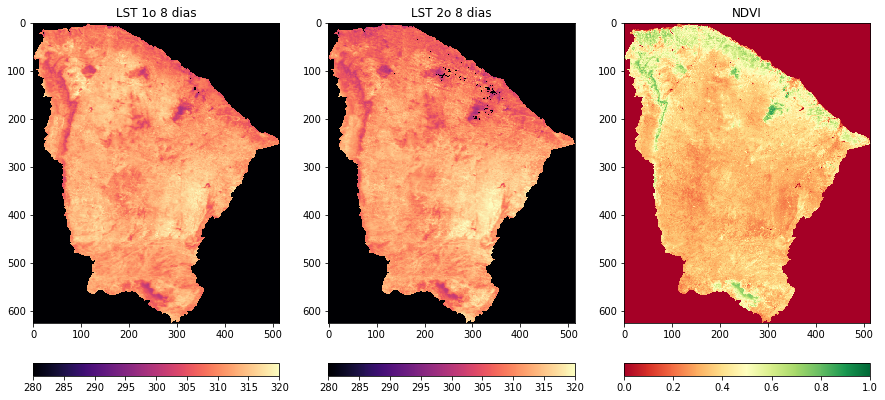

In [106]:
# Plot das imagens
dset_tss1, dset_tss2, dset_ndvi = gdal.Open(fls[0], GA_ReadOnly),\
                                  gdal.Open(fls[1], GA_ReadOnly),\
                                  gdal.Open(fls[2], GA_ReadOnly)

tss1_band, tss2_band, ndvi_band = dset_tss1.GetRasterBand(1),\
                                  dset_tss2.GetRasterBand(1),\
                                  dset_ndvi.GetRasterBand(1)

plt.figure(figsize=(15, 15))

plt.subplot(131)
plt.title("LST 1o 8 dias")
plt.imshow(tss1_band.ReadAsArray() * 0.02, cmap='magma', vmin=280, vmax=320)
plt.colorbar(orientation="horizontal", pad=0.05)

plt.subplot(132)
plt.title("LST 2o 8 dias")
plt.imshow(tss2_band.ReadAsArray() * 0.02, cmap='magma', vmin=280, vmax=320)
plt.colorbar(orientation="horizontal", pad=0.05)

plt.subplot(133)
plt.title("NDVI")
plt.imshow(ndvi_band.ReadAsArray() * 0.0001, cmap='RdYlGn', vmin=0, vmax=1)
plt.colorbar(orientation="horizontal", pad=0.05)

dset_tss1, dset_tss2, dset_ndvi = None, None, None

# **Acessar imagens**
Para igualar o período observado entre as imagens de NDVI e TSS, nesta seção é realizada uma média temporal das duas imagens TSS de 8 dias. 

In [107]:
fls = sorted(glob(path + '/*CLIP.tif'))
print(fls)

# Carregar imagens de temperatura
dset_tss1 = gdal.Open(fls[0], GA_ReadOnly)
dset_tss2 = gdal.Open(fls[1], GA_ReadOnly)

# Multiplicar pelo fator de escala
dset_tss1_band = dset_tss1.GetRasterBand(1)
dset_tss2_band = dset_tss2.GetRasterBand(1)

dset_tss1_array = dset_tss1_band.ReadAsArray() * 0.02
dset_tss2_array = dset_tss2_band.ReadAsArray() * 0.02

# Criar máscara (substituir np.nan para valores de 0, que são os valores inválidos)
dset_tss1_array[dset_tss1_array == 0] = np.nan
dset_tss2_array[dset_tss2_array == 0] = np.nan

# Calcular média temporal ignorando nan
stack_2d = np.array([dset_tss1_array, dset_tss2_array])
TSS      = scipy.nanmean(stack_2d, axis=0) # média: 311.56830648359954

# shape = dset_tss1_array.shape
# TSS = np.full((shape[0], shape[1]), np.nan) # média: 311.56830648359954 (foi achado que 400 pixels tem pelo menos um nan)
# c=0
# for ii in range(shape[0]):
#   for jj in range(shape[1]):
    
#     pix1 = dset_tss1_array[ii, jj]
#     pix2 = dset_tss2_array[ii, jj]

#     # Se for tudo nan
#     if np.isnan(pix1) and np.isnan(pix2):
#       continue
#     # Se não houver nan
#     if np.isfinite(pix1) and np.isfinite(pix2):
#       TSS[ii, jj] = (pix1 + pix2) / 2
#     # Se houver pelo menos um nan
#     if np.isfinite(pix1) and np.isnan(pix2):
#       TSS[ii, jj] = pix1
#       c += 1
#       print(c, pix1, pix2, TSS[ii, jj])
#     if np.isnan(pix1) and np.isfinite(pix2):
#       TSS[ii, jj] = pix2
#       c += 1
#       print(c, pix1, pix2, TSS[ii, jj])

# TSS = (dset_tss1_array + dset_tss2_array) / 2.   # média: 311.5789567481305

# Fechar datasets
dset_tss1, dset_tss2 = None, None

# Arredondar para duas casas decimais e printar valor médio de TSS
TSS = np.round(TSS, 2)
print(np.nanmean(TSS))
print(TSS[300, 300])

['./processed/MOD11A2.A2018257.h13v09.006.2018266035239_LST_Day_1km.MOSAIC.CLIP.tif', './processed/MOD11A2.A2018265.h13v09.006.2018282164825_LST_Day_1km.MOSAIC.CLIP.tif', './processed/MOD13A2.A2018257.h13v09.006.2018282125001_1km16daysNDVI.MOSAIC.CLIP.tif']
311.56830648359954
315.05


O acesso à imagem de NDVI segue da seguinte forma:

In [108]:
# Carregar imagem de NDVI
dset_ndvi = gdal.Open(fls[2], GA_ReadOnly)

# Multiplicar pelo fator de escala
ndvi_band = dset_ndvi.GetRasterBand(1)
NDVI = ndvi_band.ReadAsArray() * 0.0001

# Criar máscara (substituir np.nan para valores de 0, que são os valores inválidos)
NDVI[NDVI == -0.3] = np.nan
print(NDVI)

# Fechar dataset
dset_ndvi = None

# Arredondar para duas casas decimais e printar valor médio de NDVI
NDVI = np.round(NDVI, 2)
print(np.nanmean(NDVI))

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
0.37717081425874893


Visualizar dados

<function matplotlib.pyplot.show>

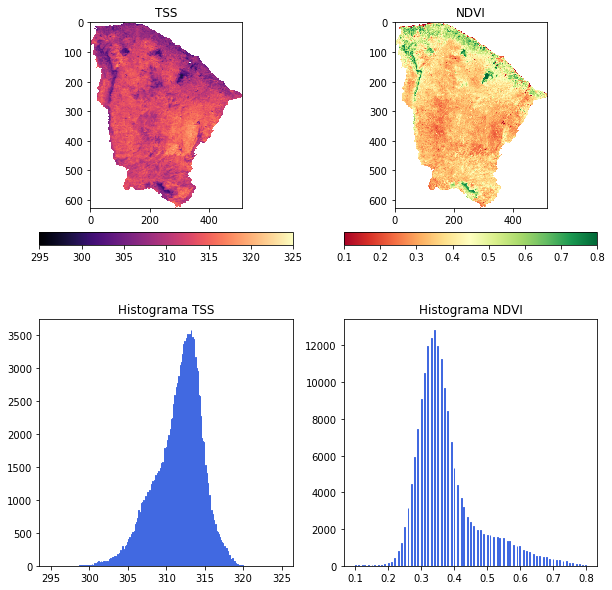

In [113]:
plt.figure(figsize=(10,10))

plt.subplot(221)
plt.title("TSS")
plt.imshow(TSS, cmap='magma', vmin=295, vmax=325)
plt.colorbar(orientation="horizontal", pad=0.1)

plt.subplot(222)
plt.title("NDVI")
plt.imshow(NDVI, cmap='RdYlGn', vmin=0.1, vmax=0.8)
plt.colorbar(orientation="horizontal", pad=0.1)

plt.subplot(223)
plt.title("Histograma TSS")
plt.hist(TSS.ravel(), bins=256, range=(295, 325), histtype='barstacked', fc='royalblue', ec='royalblue')

plt.subplot(224)
plt.title("Histograma NDVI")
plt.hist(NDVI.ravel(), bins=256, range=(0.1, 0.8), histtype='barstacked', fc='royalblue', ec='royalblue')

plt.show

# **Tratamento dos dados**

Criar matrizes de Latitude e Longitude

In [0]:
# GetGeoTransform()

# lat lon arrays
# lats, lons = np.meshgrid(vector_lat), np.meshgrid(vector_lon)

# gt = ds.GetGeoTransform()
# x = np.linspace(gt[0], gt[0] + gt[1] * data.shape[1], data.shape[1])
# y = np.linspace(gt[3], gt[3] + gt[5] * data.shape[0], data.shape[0])

# xx, yy = numpy.meshgrid(x, y)

Eliminar outliers

# **Cálculo das retas**

Criar matriz 4D

Retirar valores máximos e mínimos

Retirar coeficientes *a* e *b* para cálculo do TVDI

# **Cálculo do TVDI**

Cálculo

Criar matriz 5D e salvar dados (NetCDF?) 

Salvar imagem TVDI em formato GeoTIFF